In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.2e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(13, 18, 1)
ee = np.arange(1,11,1)
em = np.arange(50,650,50)
em = np.append([1,10],em)
atom = [13,20,32,50,79]



rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * ee / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_wo = 1548.187 # cm
C_IV_H_wo = 1550.772  # cm

cc = c.to(u.cm / u.s).value
v_th = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952

directory_1 = '~/RT/C_IV/code_tes/data_vel/'

cc_k = c.to(u.km / u.s).value

def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

# plt.plot(del_V_space_g,yy_g)

3.39e+13


In [2]:
x= 2

In [48]:
nu = 0
for a , index in enumerate(rr):
    for b, expand in enumerate(ee):
        if expand == 10 :
            expand_v = 1
            num_ev = 3 
        else: 
            num_ev = 2
            expand_v = expand
        for c, emit in enumerate(em):
            if emit == 1 :
                 emit_v = 100
                 num_emit = 0

            elif emit == 50 or emit == 10:
                emit_v = emit * 10
                num_emit = 1
            else : 
                emit_v = emit
                num_emit = 2

            for d, atom_n in enumerate(atom):
                path_sp_1 = f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}00E+0{num_ev}_Vemit{emit_v}E+0{num_emit}_tauD000E+00_Vran118E+01spec_com.dat'         
                try:
                    data_sp_1 = pd.read_csv(path_sp_1, sep='\s+', header=None)
                except FileNotFoundError:
                    print(f"파일을 찾을 수 없습니다: {path_sp_1}")
                    nu += 1
                    continue 

                
                sp_dlam_1 = data_sp_1[0].to_numpy()
                globals()[f'Lambda_{atom_n}_{index}_{expand}_{emit}'] =   sp_dlam_1
                sp_1 = data_sp_1[1].to_numpy()

                indices_K_1 = np.where(sp_dlam_1 <= 1550)[0]
                indices_H_1 = np.where(sp_dlam_1 > 1550)[0]

                sp_dlam_K = sp_dlam_1[indices_K_1]
                sp_dlam_H = sp_dlam_1[indices_H_1]

                dlam_k = sp_dlam_K[1]-sp_dlam_K[0]
                dlam_h = sp_dlam_H[1]-sp_dlam_H[0]
                dlam_sp =sp_dlam_1[1] -sp_dlam_1[0]
                # print(dlam_k ,dlam_h,dlam_sp)

                sp_K = sp_1[indices_K_1]
                sp_H = sp_1[indices_H_1]

                if len(sp_K) == 0 or len(sp_H) == 0:
                    print(f"데이터 부족: {path_sp_1}")
                    continue

                del_V_space = (sp_dlam_1 / C_IV_K_wo  - 1) * cc / 1e5  # km/s

                lam_c = (C_IV_H_wo+C_IV_K_wo) / 2
                # print(sep_point)
                indices_K_sp = np.where(sp_dlam_1 <= lam_c )[0]
                indices_H_sp = np.where(sp_dlam_1> lam_c)[0]

                int_Vel_K = del_V_space[indices_K_sp]
                int_Vel_H = del_V_space[indices_H_sp]

                int_flux_K = sp_1[indices_K_sp]
                int_flux_H = sp_1[indices_H_sp]

                delta_lam_K = sp_dlam_1[indices_K_sp]
                delta_lam_H = sp_dlam_1[indices_H_sp]
                globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_K
                globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit}'] = delta_lam_H  


                globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_K 
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_K

                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'] = int_Vel_H  
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'] = int_flux_H             
print(nu)

0


In [49]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_wo ) / C_IV_K_wo ) * cc_k
    tv_h = ((xx-C_IV_H_wo) / C_IV_H_wo ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_wo + C_IV_K_wo)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >=lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

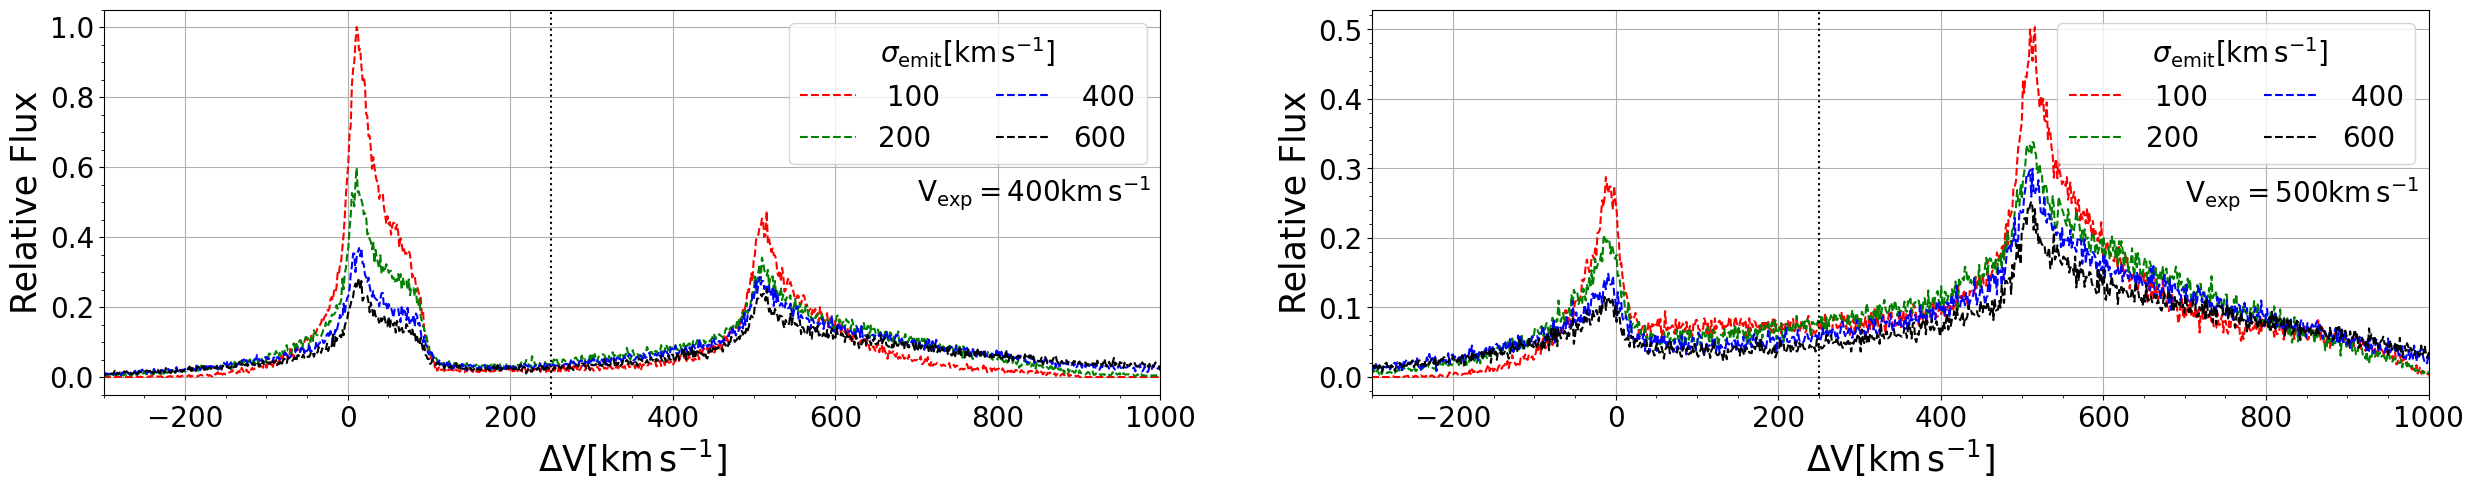

In [50]:
fig = plt.figure(1,figsize=(30,5))

plt.subplot(121)
atom_n,index, expand = 32,15,4
emit_n = 100
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--')


vv = ((C_IV_H_wo/C_IV_K_wo-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r'$\sigma_{{\rm emit}} [\rm km \, s^{{-1}} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.5,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(122)
atom_n,index, expand = 32,15,5
emit_n = 100
# normal = max(globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal,'r--')

emit_n = 200
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal ,'g--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'g--')

emit_n = 400
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--',label=f' {emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'b--')

emit_n = 600
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--',label=f'{emit_n}')
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/ normal,'k--')


vv = ((C_IV_H_wo/C_IV_K_wo-1)*cc_k /2)
plt.axvline(vv ,ymin=0,ymax=10,color='k',linestyle=':')
plt.xlim(-300, 1000)
plt.minorticks_on()
# plt.xlim(-1500,1500)
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=2,title=r' $\sigma_{\rm emit} [\rm km \, s^{-1} ]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V [\rm km \, s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.text(700,0.25,f'$\\rm V_{{\\rm exp}} = {expand}00 \\rm km \\, s^{{-1}}$',size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_emit_vexp.pdf',bbox_inches='tight')

In [51]:
def ratio(x_1,y_1,x_2,y_2):
    delx_1 = x_1[1]- x_1[0]
    total_1 = np.sum(y_1*delx_1,axis=0)
    delx_2 = x_2[1]- x_2[0]
    total_2 = np.sum(y_2*delx_2,axis=0)
    ratio = total_1 / total_2
    return ratio

def function(sigma,lam,lam_k,lam_h):
    tv_k = ((lam-lam_k) / lam_k ) * cc_k
    tv_h = ((lam-lam_h) / lam_h ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    return fx , f0

NN = 10000
x = np.linspace(1530,1570,NN)
sigma_tt = np.arange(10,610,10)
C_IV_K = 1548.187 # cm
C_IV_H = 1550.772  # cm
R_c_tt = np.zeros(len(sigma_tt)) 
lam_c = (C_IV_H +C_IV_K) / 2
for ii, sig in (enumerate(sigma_tt)):
    ff,f0 = function(sig,x,C_IV_K,C_IV_H)
    xx_k = x[x<=lam_c]
    xx_h = x[x>lam_c]   
    ff_k = ff[x<=lam_c]
    ff_h = ff[x>lam_c] 
    dlam = x[1]-x[0]
    flux_k = np.sum(ff_k*dlam,axis=0)
    flux_h = np.sum(ff_h*dlam,axis=0)
    R_c_tt[ii] = flux_k/ flux_h


NN = 10000
x = np.linspace(1530,1570,NN)

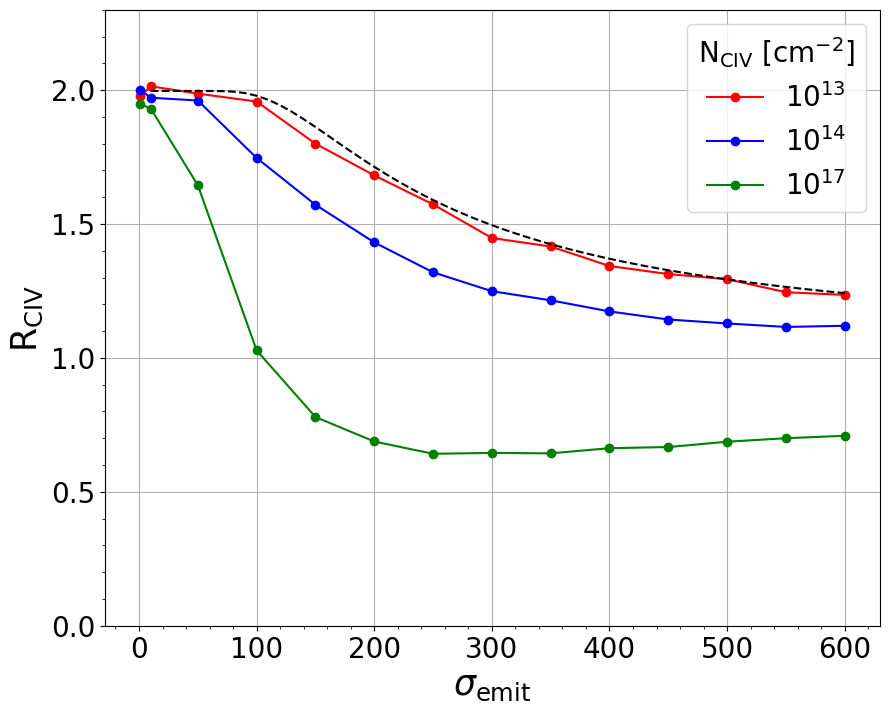

In [66]:
fig = plt.figure(1,figsize=(10,8))
atom_n, expand = 32, 4

# 첫 번째 조합: index = 13
index = 13
first_label = True
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'ro-', label=f'$10^{{{index}}}$')

# 두 번째 조합: index = 15
index = 14
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'bo-', label=f'$10^{{{index}}}$')

# 세 번째 조합: index = 17
index = 17
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'go-', label=f'$10^{{{index}}}$')

plt.legend(fontsize=20,title=f'$\\rm N_{{\\rm CIV}} ~[\\rm cm^{{-2}}]$',title_fontsize=20)
plt.plot(sigma_tt,R_c_tt,'k--')
plt.ylim(0,2+0.3)
plt.xlabel(r'$\sigma_{\rm emit}$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.grid(True)
plt.minorticks_on()
# plt.savefig(r'/home/jin/바탕화면/Vexp_400_N_CIV_emit.pdf',bbox_inches='tight')

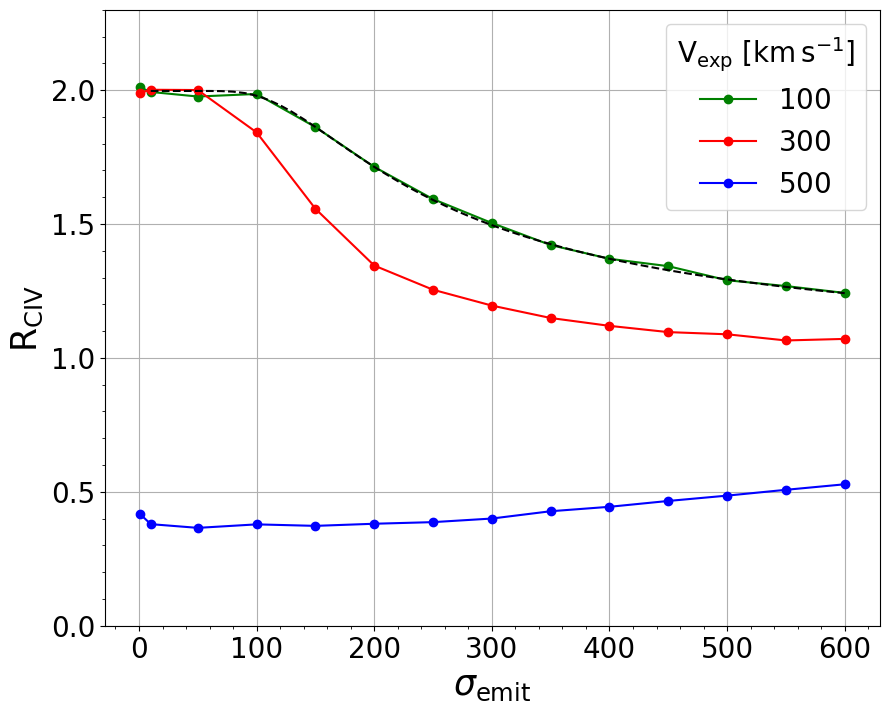

In [70]:
fig = plt.figure(1,figsize=(10,8))
atom_n, index= 32, 15

# 첫 번째 조합: index = 13
expand = 1
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'go-', label=f'${expand}00$')

# 두 번째 조합: index = 15
expand = 3
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'ro-', label=f'${expand}00$')

# 세 번째 조합: index = 17
expand = 5
Ratio = np.zeros(len(em))
for ii, emit_n in enumerate(em):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit_n}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}'])
    Ratio[ii] = R_C
plt.plot(em, Ratio, 'bo-', label=f'${expand}00$')
# $\\rm V_{{\\rm exp}} = {expand}00 km \, s^{{{-1}}}$
plt.legend(fontsize=20,title=f'$\\rm V_{{\\rm exp}}  ~ [km \, s^{{{-1}}}]$',title_fontsize=20)
plt.plot(sigma_tt,R_c_tt,'k--')
plt.ylim(0,2+0.3)
plt.xlabel(r'$\sigma_{\rm emit}$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_Vexp_emit.pdf',bbox_inches='tight')

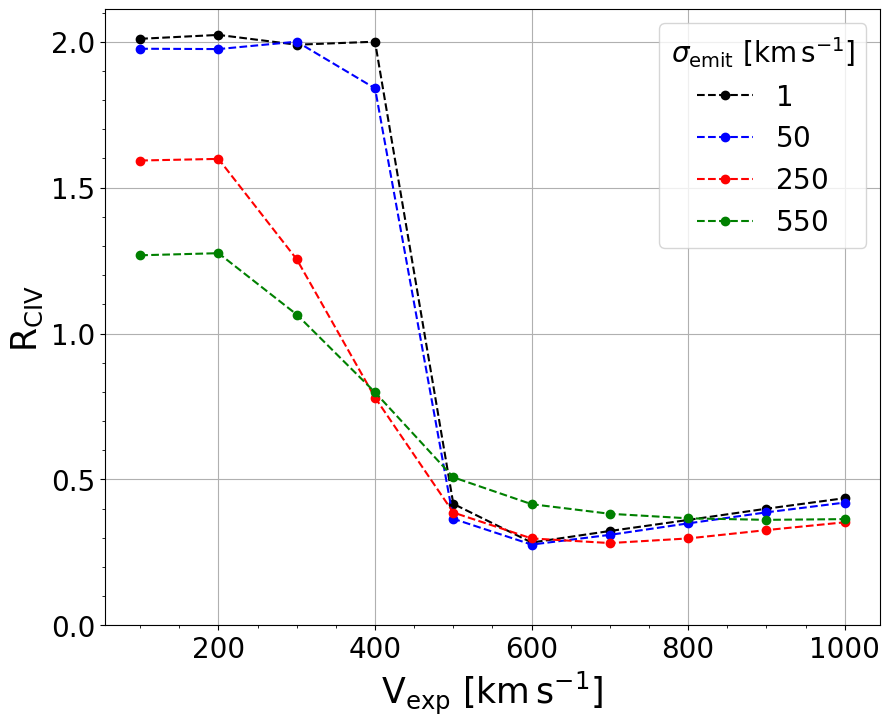

In [57]:
fig = plt.figure(1,figsize=(10,8))
atom_n, index= 32, 15

emit = 1
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
    Ratio[ii] = R_C
    velocity[ii] = expand * 100 
plt.plot(velocity, Ratio,'ko--',label= f'${emit} $')


emit = 50
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
    Ratio[ii] = R_C
    velocity[ii] = expand * 100 
plt.plot(velocity, Ratio,'bo--',label= f'${emit} $')

emit = 250
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
    Ratio[ii] = R_C
    velocity[ii] = expand * 100 
plt.plot(velocity, Ratio,'ro--',label= f'${emit} $')


emit = 550
first_label = True

Ratio = np.zeros(len(ee))
velocity = np.zeros(len(ee))
for ii, expand in enumerate(ee):
    R_C = ratio(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],
                globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])
    Ratio[ii] = R_C
    velocity[ii] = expand * 100 
plt.plot(velocity, Ratio,'go--',label= f'${emit} $')
# $\\rm V_{{\\rm exp}} = {expand}00 km \, s^{{{-1}}}$
plt.legend(fontsize=20,title=f'$\\sigma_{{\\rm emit}} ~ [\\rm km \\, s^{{-1}}]$',title_fontsize=20)
# plt.plot(sigma_tt,R_c_tt,'k--')
# plt.ylim(0,2+0.3)
plt.xlabel(r'$\rm V_{\rm exp} ~[\rm km\, s^{-1}]$',fontsize=25)
plt.ylabel(r'$\rm R_{\rm CIV}$',fontsize=25)
plt.yticks([0.0,0.5,1.0,1.5,2.0],fontsize=20)
plt.xticks(fontsize=20)
plt.minorticks_on()
plt.grid(True)
# plt.savefig(r'/home/jin/바탕화면/N_CIV_15_to_expandv_emit.pdf',bbox_inches='tight')

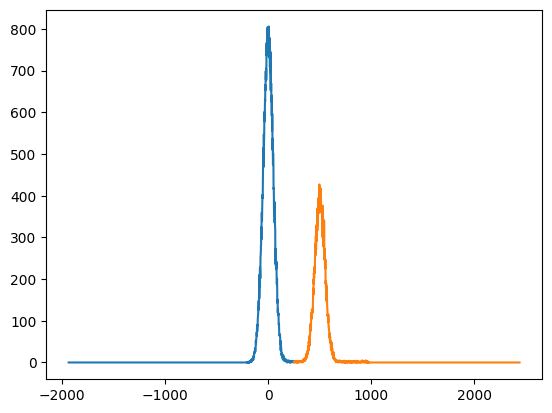

In [55]:
atom_n, index= 32, 13
expand =5
emit = 50
plt.plot(globals()[f'I_K_dv_{atom_n}_{index}_{expand}_{emit}'],globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit}'])
plt.plot(globals()[f'I_H_dv_{atom_n}_{index}_{expand}_{emit}'],globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit}'])


1500 1500


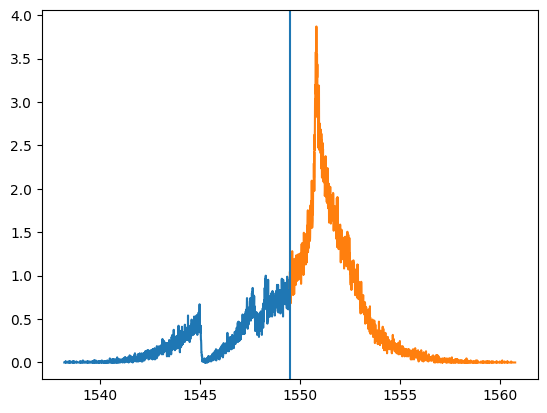

In [56]:
atom_n, index= 32, 15
expand = 6
emit_n= 500
NN = 10000  
# expand = 7
xx = np.linspace(1530,1570,NN)
normal = max(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}'])
plt.plot(globals()[f'delta_lam_K_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']/normal )
plt.plot(globals()[f'delta_lam_H_{atom_n}_{index}_{expand}_{emit_n}'] ,globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']/normal )
print(len(globals()[f'I_K_f_{atom_n}_{index}_{expand}_{emit_n}']) ,len(globals()[f'I_H_f_{atom_n}_{index}_{expand}_{emit_n}']) )
plt.axvline(lam_c ,0,1)
# plt.plot(xx,globals()[f'analy_fx_{emit_n}'])